In [1]:
import pandas as pd

In [2]:
df_sub = pd.read_csv('data/SampleSubmissionStage2.csv')
df_kp = pd.read_csv('data/Final/final_raw_kp_dat.csv')
df_seed = pd.read_csv('data/Final/final_raw_seeds.csv')

In [3]:
ken_pom = pd.read_csv('data/Final/final_kp_dat.csv')
ken_pom.head()

,TeamID,year,ADJOE,ADJDE,Luck
0,1438,2019,123.6,88.1,0.024
1,1438,2018,115.2,85.6,0.048
2,1438,2017,112.2,88.0,-0.030
3,1438,2016,120.6,91.0,-0.040
4,1438,2015,115.6,85.5,0.023


### Prepare Submission file 

To be a test dataset

In [4]:
df_sub[['Season','low_seed','high_seed']] = df_sub['ID'].str.split('_',expand=True).astype(int)

In [5]:
df_sub = pd.merge(df_sub,df_seed,how='inner',
                 left_on=['Season','low_seed'],
                 right_on=['Season','TeamID']).rename(columns={'Seed':'L_SEED'})
df_sub = pd.merge(df_sub,df_seed,how='inner',
                 left_on=['Season','high_seed'],
                 right_on=['Season','TeamID']).rename(columns={'Seed':'W_SEED'})

In [6]:
df_sub2 = df_sub.drop(['TeamID_x','TeamID_y'],axis=1)

In [7]:
df_sub2 = pd.merge(df_sub2,ken_pom,how='inner',
                   left_on=['Season','low_seed'],
                   right_on = ['year','TeamID']).drop('TeamID',axis=1)
df_sub2 = pd.merge(df_sub2,ken_pom,how='inner',
                   left_on=['Season','high_seed'],
                   right_on = ['year','TeamID'],suffixes=('_L','_W')).drop('TeamID',axis=1)

In [8]:
df_sub2['Seed_Diff'] = df_sub2['L_SEED'] - df_sub2['W_SEED']
df_sub2['ADJ_OE_Diff'] = df_sub2['ADJOE_L'] - df_sub2['ADJOE_W']
df_sub2['ADJ_DE_Diff'] = df_sub2['ADJDE_L'] - df_sub2['ADJDE_W']
df_sub2['Luck_Diff'] = df_sub2['Luck_L'] - df_sub2['Luck_W']

In [9]:
df_test = df_sub2[['Seed_Diff','ADJ_OE_Diff','ADJ_DE_Diff','Luck_Diff']]

In [10]:
df_test.head()

,Seed_Diff,ADJ_OE_Diff,ADJ_DE_Diff,Luck_Diff
0,4,-6.2,3.0,0.041
1,10,-16.0,5.3,0.084
2,6,-9.8,2.3,0.043
3,6,-9.9,3.3,0.119
4,2,-3.7,0.3,0.078


## Build Model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [12]:
df_train = pd.read_csv('data/Final/data_kp_seed.csv')

In [13]:
y = df_train['result'].values

In [14]:
X = df_train.drop('result',axis=1)

In [15]:
X = X.fillna(0)

In [16]:
logreg = LogisticRegression(solver='lbfgs')
params = {'tol':np.arange(0.0, 0.5, 0.01),'C': np.logspace(start=-5, stop=3, num=9)}
clf = RandomizedSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X, y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

/Users/meyappansubbaiah/Documents/Github/March_Madness_KG/.env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best log_loss: -0.4708, with best C: 10.0


In [17]:
clf.best_params_

{'tol': 0.11, 'C': 10.0}

In [18]:
final_reg = LogisticRegression(**clf.best_params_)

In [19]:
final_reg.fit(X,y)

/Users/meyappansubbaiah/Documents/Github/March_Madness_KG/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.11, verbose=0, warm_start=False)

In [20]:
df_final_sub = pd.read_csv('data/SampleSubmissionStage2.csv')

In [21]:
clipped_preds = np.clip(final_reg.predict_proba(df_test)[:,1], 0.05, 0.95)

In [22]:
df_final_sub['Pred'] = clipped_preds

In [23]:
%matplotlib inline

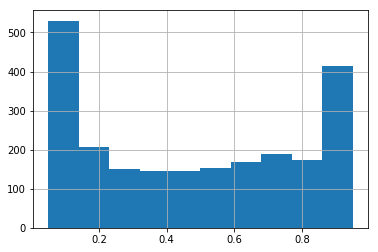

In [24]:
df_final_sub['Pred'].hist()

In [25]:
df_final_sub.to_csv('data/Final/Results/logreg_seed_diff.csv',index=False)

In [26]:
df_final_sub

,ID,Pred
0,2019_1101_1113,0.185865
1,2019_1101_1120,0.050000
2,2019_1101_1124,0.134837
3,2019_1101_1125,0.111836
4,2019_1101_1133,0.350770
5,2019_1101_1138,0.772513
6,2019_1101_1153,0.139108
7,2019_1101_1159,0.409446
8,2019_1101_1181,0.813354
9,2019_1101_1192,0.556942
